<a href="https://colab.research.google.com/github/Riipou/First-order/blob/main/Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [81]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

# Chargement et pré-traitement des données

In [82]:
def one_hot_encoding(y):
    new_y = []
    for label in y:
        label_vector = np.zeros(20)
        label_vector[label - 1] = 1
        new_y.append(label_vector)
    y = np.array(new_y)
    return y

def shuffle(X, y):
    index = np.arange(np.shape(X)[1])
    np.random.shuffle(index)
    X = X[:, index]
    y = y.T[:, index]
    return X, y

def split_data(X, y, split_value=0.85):
    m = X.shape[1]
    m = int(m * split_value)
    X_train = X[:, :m]
    y_train = y[:m, :]
    X_test = X[:, m:]
    y_test = y[m:, :]
    return X_train, y_train, X_test, y_test

In [83]:
# Charger le fichier .mat
nom_fichier_mat = 'data_doc.mat'
donnees = loadmat(nom_fichier_mat)

# Xts combien de fois le mot dans le texte
if 'Xts' in donnees:
    Xts = donnees['Xts']
else:
    print("La variable 'Xts' n'a pas été trouvée dans le fichier.")

# id texte avec classe
if 'yts' in donnees:
    yts = donnees['yts']
else:
    print("La variable 'yts' n'a pas été trouvée dans le fichier.")

# Xvr combien de fois le mot dans le texte
if 'Xvr' in donnees:
    Xvr = donnees['Xvr']
else:
    print("La variable 'Xvr' n'a pas été trouvée dans le fichier.")

yts = one_hot_encoding(yts)
Xts, yts = shuffle(Xts, yts)
X_train, y_train, X_test, y_test = split_data(Xts, yts.T)

# Variables

In [84]:
num_iterations=100
learning_rate=0.9
a = 0.05

#Descente du gradient

In [85]:
def loss_function(y, y_pred):
    n = y.shape[1]
    loss = (np.linalg.norm(y - y_pred, 'fro') ** 2) / n
    return loss

def relu(x, a):
    return np.maximum(0, a * x)


def sigmoid(x, a):
    return 1 / (1 + np.exp(-a * x))

def sigmoid_derivative(x, a):
    return a * sigmoid(x, a) * (1 - sigmoid(x, a))

def update_W1(X, Y, W1, b1, learning_rate, a):
    n = Y.shape[1]
    sigmoid_derivative_term = sigmoid_derivative(W1 @ X + b1, a)

    gradient = X @ ((1/n) * (sigmoid(W1 @ X + b1, a) - Y) * sigmoid_derivative_term).T
    update = learning_rate * gradient

    return update.T

def update_b1(X, Y, W1, b1, learning_rate, a):
    n = Y.shape[1]
    ones_vector = np.ones((1, n))
    sigmoid_derivative_term = sigmoid_derivative(W1 @ X + b1, a)

    gradient = (1/n) * np.sum((sigmoid(W1 @ X + b1, a) - Y) * sigmoid_derivative_term * ones_vector, axis=1, keepdims=True)
    update = learning_rate * gradient

    return update

def block_coordinate_descent(X, Y, W1, b1, num_iterations, learning_rate, a):
    train_losses = []  # Pour stocker les pertes d'entraînement à chaque itération
    accuracies = []  # Pour stocker les accuracies à chaque itération

    for k in range(num_iterations):
        # Optimize W1 while fixing b1
        W1 -= update_W1(X, Y, W1, b1, learning_rate, a)

        # Optimize b1 while fixing W1
        b1 -= update_b1(X, Y, W1, b1, learning_rate, a)

        # Calculate and print the loss for monitoring every 10 iterations
        if (k + 1) % 10 == 0:
            Y_pred = sigmoid(W1 @ X + b1, a)
            loss = loss_function(Y, Y_pred)
            accuracy = np.mean(np.round(Y_pred) == Y)
            train_losses.append(loss)
            accuracies.append(accuracy)
            print(f"Iteration {k+1}, Loss: {loss}, Accuracy: {accuracy * 100}%")

    return W1, b1, train_losses, accuracies

In [86]:
# Initialisation des poids
b1_initial = np.random.randn(20, 1)

# Avec une distribution normal
# W1_initial = np.random.randn(20, X_train.shape[0])

# Avec l'initialisation Xavier/Glorot
W1_initial = np.random.randn(20, X_train.shape[0]) * np.sqrt(2.0 / (X_train.shape[0] + 20))


W1_optimized, b1_optimized, train_losses, accuracies = block_coordinate_descent(X_train, y_train.T, W1_initial, b1_initial, num_iterations, learning_rate, a)

# Now nous W1_optimized and b1_optimized

Iteration 10, Loss: 4.917042908135304, Accuracy: 60.4816281813585%
Iteration 20, Loss: 4.8488925969104555, Accuracy: 67.36010450025283%
Iteration 30, Loss: 4.784619362310686, Accuracy: 73.69290409573571%
Iteration 40, Loss: 4.723677809303407, Accuracy: 78.64908140906792%
Iteration 50, Loss: 4.665563754749047, Accuracy: 82.27920107871228%
Iteration 60, Loss: 4.609877372241724, Accuracy: 84.96460475307602%
Iteration 70, Loss: 4.556317916569705, Accuracy: 87.03775493005224%
Iteration 80, Loss: 4.504660632514101, Accuracy: 88.65624473285017%
Iteration 90, Loss: 4.454734606849244, Accuracy: 89.89844935108714%
Iteration 100, Loss: 4.406406036288032, Accuracy: 90.87645373335582%


# Evaluation des données


Final Test Loss: 4.4000076706235, Test Accuracy: 90.85004775549189%


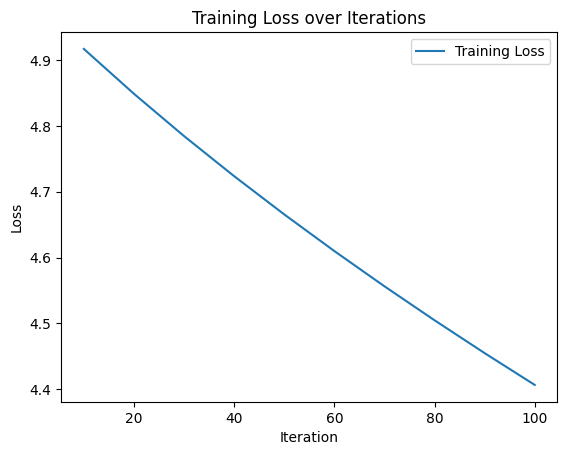

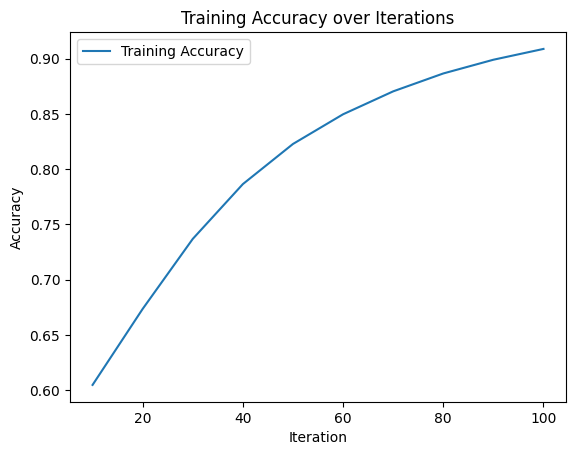

In [87]:
Y_test_pred = sigmoid(W1_optimized @ X_test + b1_optimized, a)
test_loss = loss_function(y_test.T, Y_test_pred)
test_accuracy = np.mean(np.round(Y_test_pred) == y_test.T)
print(f"\nFinal Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%")

# Plot the training loss
plt.plot(range(10, num_iterations + 1, 10), train_losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.show()

# Plot the training accuracy
plt.plot(range(10, num_iterations + 1, 10), accuracies, label='Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Iterations')
plt.legend()
plt.show()